
--- Cross-Validation Results (on Training Set) ---
CV R² score for N2O: 0.964
CV RMSE for N2O: 0.014
CV R² score for CH4: 0.987
CV RMSE for CH4: 0.008

--- Final Evaluation on Held-out Test Set ---
Test R² score for N2O: 0.961
Test RMSE for N2O: 0.014
Test R² score for CH4: 0.987
Test RMSE for CH4: 0.008


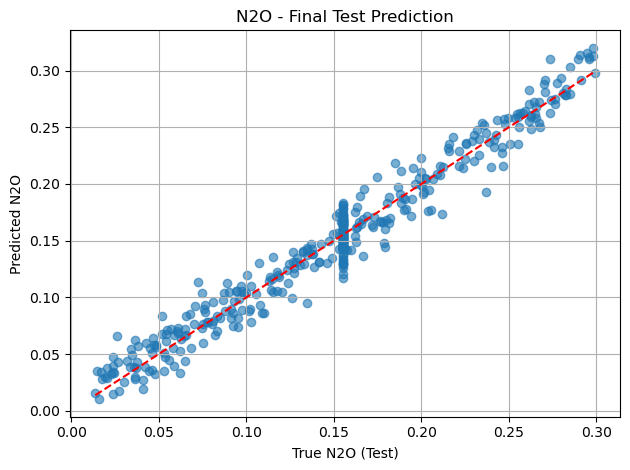

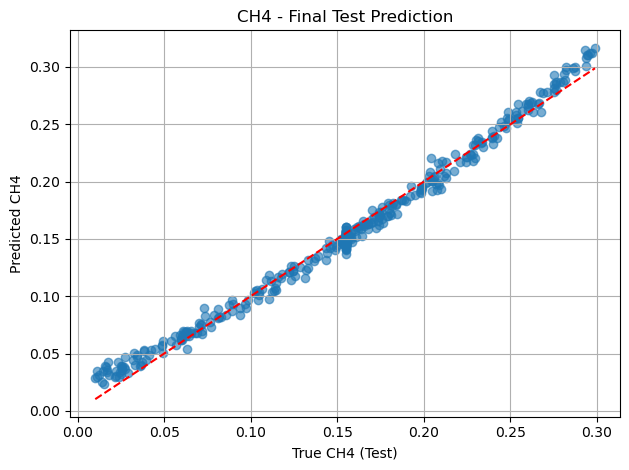

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_predict, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

gasA = "N2O"
gasB = "CH4"
gases = [gasA, gasB]

# --- Load spectra and labels ---
spectra_df = pd.read_csv(f"{gasA}_{gasB}_spectra_double_noisy.csv")
labels_df = pd.read_csv(f"{gasA}_{gasB}_label_double.csv")
X = spectra_df
y = labels_df[[gasA, gasB]]

# --- Standardize spectra ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, shuffle=True)

# --- Cross-validation on training set ---
cv = KFold(n_splits=10, shuffle=True)
n_components = 15
pls_cv = PLSRegression(n_components=n_components)
y_train_cv_pred = cross_val_predict(pls_cv, X_train, y_train, cv=cv)

# --- Evaluate cross-validated performance ---
r2_A_cv = r2_score(y_train[gasA], y_train_cv_pred[:, 0])
r2_B_cv = r2_score(y_train[gasB], y_train_cv_pred[:, 1])
rmse_A_cv = mean_squared_error(y_train[gasA], y_train_cv_pred[:, 0], squared=False)
rmse_B_cv = mean_squared_error(y_train[gasB], y_train_cv_pred[:, 1], squared=False)

print("\n--- Cross-Validation Results (on Training Set) ---")
print(f"CV R² score for {gasA}: {r2_A_cv:.3f}")
print(f"CV RMSE for {gasA}: {rmse_A_cv:.3f}")
print(f"CV R² score for {gasB}: {r2_B_cv:.3f}")
print(f"CV RMSE for {gasB}: {rmse_B_cv:.3f}")

# --- Train final model on full training set and evaluate on test set ---
pls_final = PLSRegression(n_components=n_components)
pls_final.fit(X_train, y_train)
y_test_pred = pls_final.predict(X_test)

r2_A_test = r2_score(y_test[gasA], y_test_pred[:, 0])
r2_B_test = r2_score(y_test[gasB], y_test_pred[:, 1])
rmse_A_test = mean_squared_error(y_test[gasA], y_test_pred[:, 0], squared=False)
rmse_B_test = mean_squared_error(y_test[gasB], y_test_pred[:, 1], squared=False)

print("\n--- Final Evaluation on Held-out Test Set ---")
print(f"Test R² score for {gasA}: {r2_A_test:.3f}")
print(f"Test RMSE for {gasA}: {rmse_A_test:.3f}")
print(f"Test R² score for {gasB}: {r2_B_test:.3f}")
print(f"Test RMSE for {gasB}: {rmse_B_test:.3f}")

# --- Plot predictions ---
for i, gas in enumerate(gases):
    
    # Test set
    plt.figure()
    plt.scatter(y_test[gas], y_test_pred[:, i], alpha=0.6)
    plt.xlabel(f"True {gas} (Test)")
    plt.ylabel(f"Predicted {gas}")
    plt.title(f"{gas} - Final Test Prediction")
    plt.plot([y_test[gas].min(), y_test[gas].max()],
             [y_test[gas].min(), y_test[gas].max()], 'r--')
    plt.grid(True)
    plt.tight_layout()

plt.show()


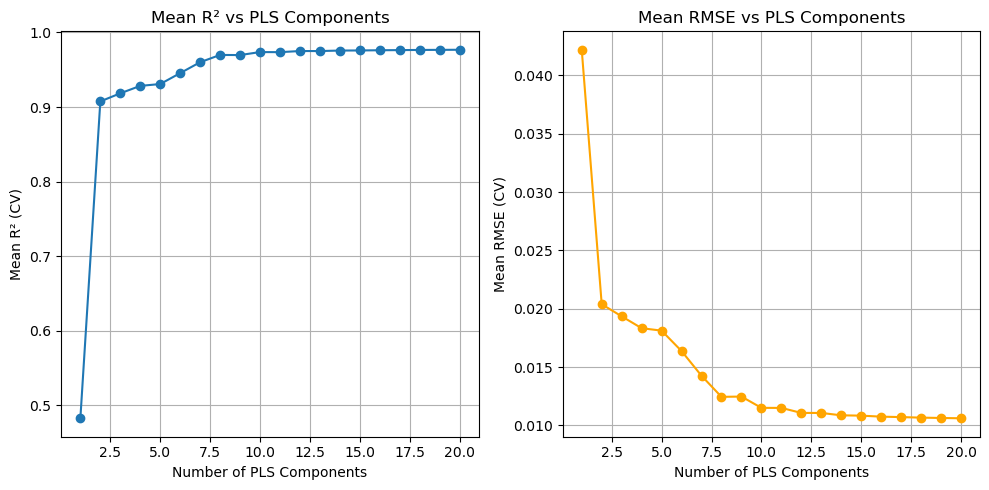

Optimal number of PLS components: 20

Final Model with 20 components:
R² score for N2O: 0.965
RMSE for N2O: 0.014
R² score for CH4: 0.988
RMSE for CH4: 0.008


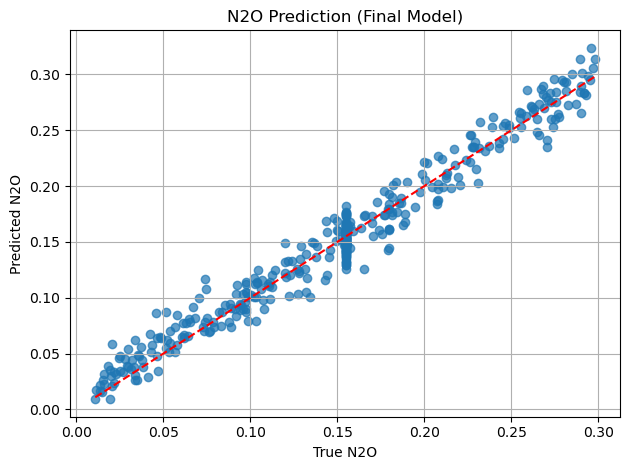

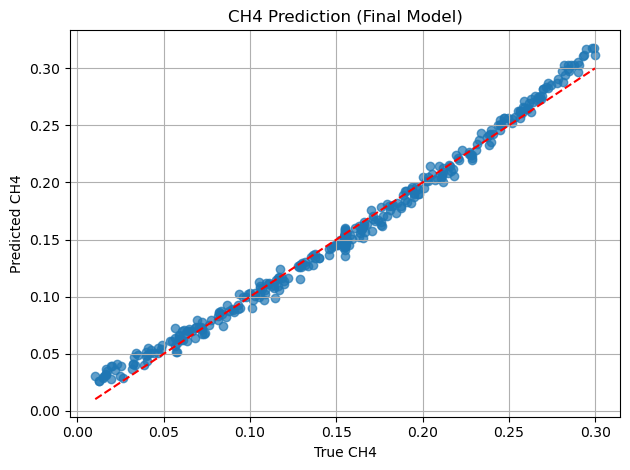

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score, mean_squared_error

gasA = "N2O"
gasB = "CH4"

# --- Load data ---
spectra_df = pd.read_csv(f"{gasA}_{gasB}_spectra_double_noisy.csv")
labels_df = pd.read_csv(f"{gasA}_{gasB}_label_double.csv")

X = spectra_df.values
y = labels_df[[gasA, gasB]].values

# --- Standardize ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Cross-validation to find optimal components ---
kf = KFold(n_splits=10, shuffle=True, random_state=42)
max_components = min(30, X_scaled.shape[1])

mean_r2_scores = []
mean_rmse_scores = []

for n_comp in range(1, max_components + 1):
    pls = PLSRegression(n_components=n_comp)
    r2_scores = []
    rmse_scores = []
    
    for train_idx, test_idx in kf.split(X_scaled):
        X_train_cv, X_test_cv = X_scaled[train_idx], X_scaled[test_idx]
        y_train_cv, y_test_cv = y[train_idx], y[test_idx]
        
        pls.fit(X_train_cv, y_train_cv)
        y_pred_cv = pls.predict(X_test_cv)
        
        r2 = [r2_score(y_test_cv[:, i], y_pred_cv[:, i]) for i in range(y.shape[1])]
        rmse = [mean_squared_error(y_test_cv[:, i], y_pred_cv[:, i], squared=False) for i in range(y.shape[1])]
        
        r2_scores.append(np.mean(r2))
        rmse_scores.append(np.mean(rmse))
    
    mean_r2_scores.append(np.mean(r2_scores))
    mean_rmse_scores.append(np.mean(rmse_scores))

# --- Plot metrics ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, max_components + 1), mean_r2_scores, marker='o')
plt.xlabel("Number of PLS Components")
plt.ylabel("Mean R² (CV)")
plt.title("Mean R² vs PLS Components")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, max_components + 1), mean_rmse_scores, marker='o', color='orange')
plt.xlabel("Number of PLS Components")
plt.ylabel("Mean RMSE (CV)")
plt.title("Mean RMSE vs PLS Components")
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Optimal number of components ---
optimal_components = np.argmax(mean_r2_scores) + 1
print(f"Optimal number of PLS components: {optimal_components}")